In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

# Setting up wandb

In [2]:
import wandb
import os

In [3]:
wandb.login() # entry api key

os.environ["WANDB_SILENT"]="true"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: michael-jakober to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Loading Data

In [4]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [5]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [6]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}")

Current device: cuda


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [8]:
def cnn_model():
    """
    Model with two CNN layers, one dense and an output classification layer, with suitable number of filters and units, respectively.
    :return:
    """
    # your code here
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

In [9]:
model = cnn_model().to(device)
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                  [-1, 128]         200,832
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 211,690
Trainable params: 211,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 0.81
Estimated T

### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [10]:
def train_eval(model, optimizer, n_epochs, training_loader, val_loader, scheduler=None, verbose=False, wandb_run=None):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param n_epochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param val_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :param verbose: Verbosity level
    :param wandb_run: Wandb run
    :return: Lists with training and validation cost and accuracy per epoch.
    """

    cost_hist = []
    cost_hist_val = []
    acc_hist = []
    acc_hist_val = []
    total_preds = None
    total_targets = None

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in tqdm(range(n_epochs), desc="Epoch"):
        # Training
        model.train()

        total_correct = 0
        total_train_loss = 0
        for X_train, y_train in tqdm(training_loader, disable=not verbose):
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            output = model(X_train)

            optimizer.zero_grad()
            loss = cost_ce(output, y_train)

            loss.backward()

            total_train_loss += loss.item()

            optimizer.step()
            if scheduler:
                scheduler.step()

            _, y_pred = torch.max(output, dim=1)
            correct = torch.sum(y_pred == y_train).item()
            total_correct += correct

            acc_epoch = correct / len(y_train)

            if wandb_run:
                wandb_run.log({"train_loss": loss.item(), "train_acc": acc_epoch})

        acc = total_correct / len(training_data.dataset)
        cost = total_train_loss / len(training_data)

        # validation
        model.eval()

        val_loss = 0
        total_correct = 0
        total_preds = []
        total_targets = []

        for X_val, y_val in tqdm(val_loader, disable=not verbose):
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            output = model(X_val)
            loss = cost_ce(output, y_val).item()
            val_loss += loss

            _, y_pred = torch.max(output, dim=1)
            correct = torch.sum(y_pred == y_val).item()
            total_correct += correct
            total_preds.append(y_pred.detach().cpu())
            total_targets.append(y_val.cpu())

            acc_epoch = correct / len(y_val)

            if wandb_run:
                wandb_run.log({"val_loss": loss, "val_acc": acc_epoch})


        acc_val = total_correct / len(val_loader.dataset)
        cost_val = val_loss / len(val_loader)

        if verbose:
            print(f"Epoch     : {epoch}\n"
                  f"Train Cost: {cost:.3f}\n"
                  f"Train Acc : {acc:.3f}\n"
                  f"Val Cost  : {cost_val:.3f}\n"
                  f"Val Acc   : {acc_val:.3f}")
        cost_hist.append(cost)
        cost_hist_val.append(cost_val)
        acc_hist.append(acc)
        acc_hist_val.append(acc_val)

    if wandb_run:
        wandb_run.finish()
    return cost_hist, cost_hist_val, acc_hist, acc_hist_val, torch.cat(total_preds), torch.cat(total_targets)

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

In [11]:
n_epochs = 20

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [12]:
config = {
    "learning_rate": 0.1,
    "n_epochs": n_epochs,
}

run = wandb.init(entity="michael-jakober", project="ftp_delearn_05", name="SGD_LR0.1_prerun", config=config)

train_losses, val_losses, train_accuracies, val_accuracies, predictions, targets = train_eval(model, optimizer, n_epochs, train_loader, validation_loader, verbose=False, wandb_run=run)

Epoch: 100%|██████████| 20/20 [03:16<00:00,  9.85s/it]


train_acc,▃▂▅▄▇▁▄▄▂▂▇▇▆▅▅▅▅▅▅▆▆▆▄▇▅█▆▇▅▇▇▆▇▆▅▅▇▅▃▅
train_loss,█▆▄▅▄▅▄▃▄▂▃▃▂▅▃▂▂▃▃▃▃▃▂▃▂▂▁▂▂▂▂▃▃▂▂▂▃▂▂▁
val_acc,▆▅▁▄▇▇▇▅▅▅▆▅▃▅█▅▅▇▅▆▇▇▇▇▇▅█▇▇▇▆▆▇▇▅▇▇▅▅▅
val_loss,▇▆▄▅▄▃▄▂▅▃▇▇▆█▄▅▄▅▇▃▂▅▅▄▄▃▄▄▁▃▃▂▆▇▂▂▂▁█▅
train_acc,0.9375
train_loss,0.26139
val_acc,0.9375
val_loss,0.2619


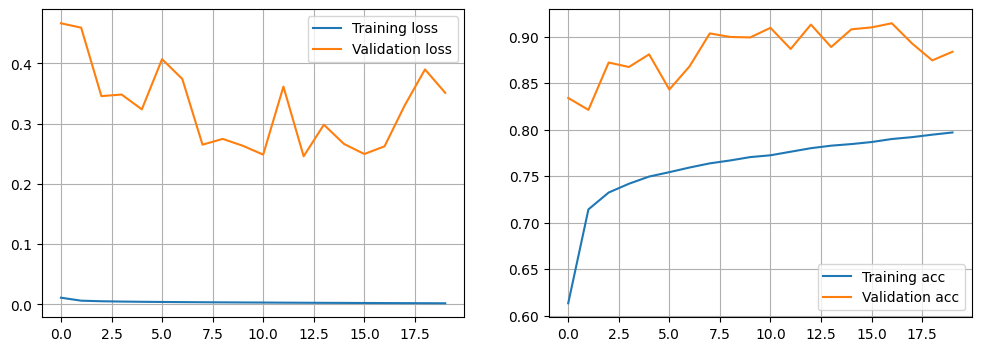

In [13]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Validation acc')
ax2.legend()
ax2.grid()

# Comments
Already at the first epoch very good accuracy on the validation set, which seems to be a bit strange, as the loss curve seems to massively overfit on the training data, with the loss being very close to 0 and the validation loss going around at 0.35. So to conclude, we would not need this many epochs, or we could use a simpler model.

The good performance on the validation set can also be seen in the confusion matrix below.

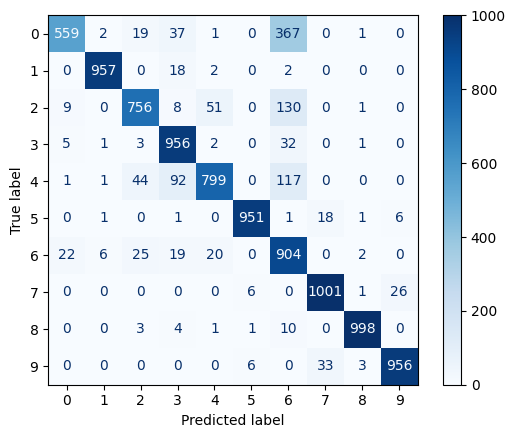

In [14]:
cm = confusion_matrix(targets, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

Epoch: 100%|██████████| 20/20 [03:17<00:00,  9.90s/it]


train_acc,▂▄▂▄▂▃▂▄▅▂▄▅▅▅▄▃▁▅▄▅▅▅▃▄▅▇▆▂▅▅▇▇▃▅▅▅▅█▅▇
train_loss,█▅▃▃▄▂▃▂▂▂▃▂▂▂▃▂▁▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
val_acc,▁▃▆▅▅▅▅▇█▆▅▇▇▆▄▆▆▆▆▆▃▁▂▅▆▄▅▆▅▆█▅▆▆▄▆▆▅▆▆
val_loss,███▄▁▄▃▄▁▃▂▄▂▂▁▅▃▁▅▅▂▃▂▁▅▁▁▂▂▃▁▂▂▄▃▂▃▄▃▃
train_acc,0.9375
train_loss,0.18117
val_acc,0.9375
val_loss,0.23754


Epoch: 100%|██████████| 20/20 [03:19<00:00,  9.95s/it]


train_acc,▁▁▄▅▆▅▆▆▅▆▅▇▆██▇███▅▇█▇▇█▇▇▇▇█▇▆▇▇████▇▇
train_loss,█▆▃▂▃▃▂▃▃▂▂▂▂▂▃▃▂▂▂▂▂▃▂▂▂▁▂▁▁▂▁▂▁▂▁▁▁▂▂▂
val_acc,▁▅▅▇▃▇▅█▇▇▅▇▆▆▇▇▇▇▆▇▅▇▅▆▇▇▆▇▆▅▆▇▅▅▇█▇▇▇█
val_loss,█▇▄▅▇▄▄▅▄▇▃▃▅▄▃▄▄▂▃▄▄▃▃▆▂▃▅▂▄▃▃▃▃▃▄▂▁▁▂▁
train_acc,0.8125
train_loss,0.42553
val_acc,0.875
val_loss,0.33779


Epoch: 100%|██████████| 20/20 [03:17<00:00,  9.86s/it]


train_acc,▁▂▅▄▅▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇▇███▇▇█▇██▇██▇██▇
train_loss,█████▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▁▁▂▁▂▂▁▁▂▂▁▁▂▂▁▂▁▂▂
val_acc,▁▅▅▅▇▆▇▅▅▆▆▇▇▆▆▇▇▇▇▇▆▇▇▆▇▆▇█▇▇▇▆▆▆▇▆▇▇▇█
val_loss,██▃▃▂▂▃▃▂▁▂▂▂▁▂▂▂▂▃▃▂▂▂▂▂▁▂▂▃▂▂▁▂▁▁▂▁▂▂▂
train_acc,0.875
train_loss,0.44317
val_acc,0.9375
val_loss,0.35206


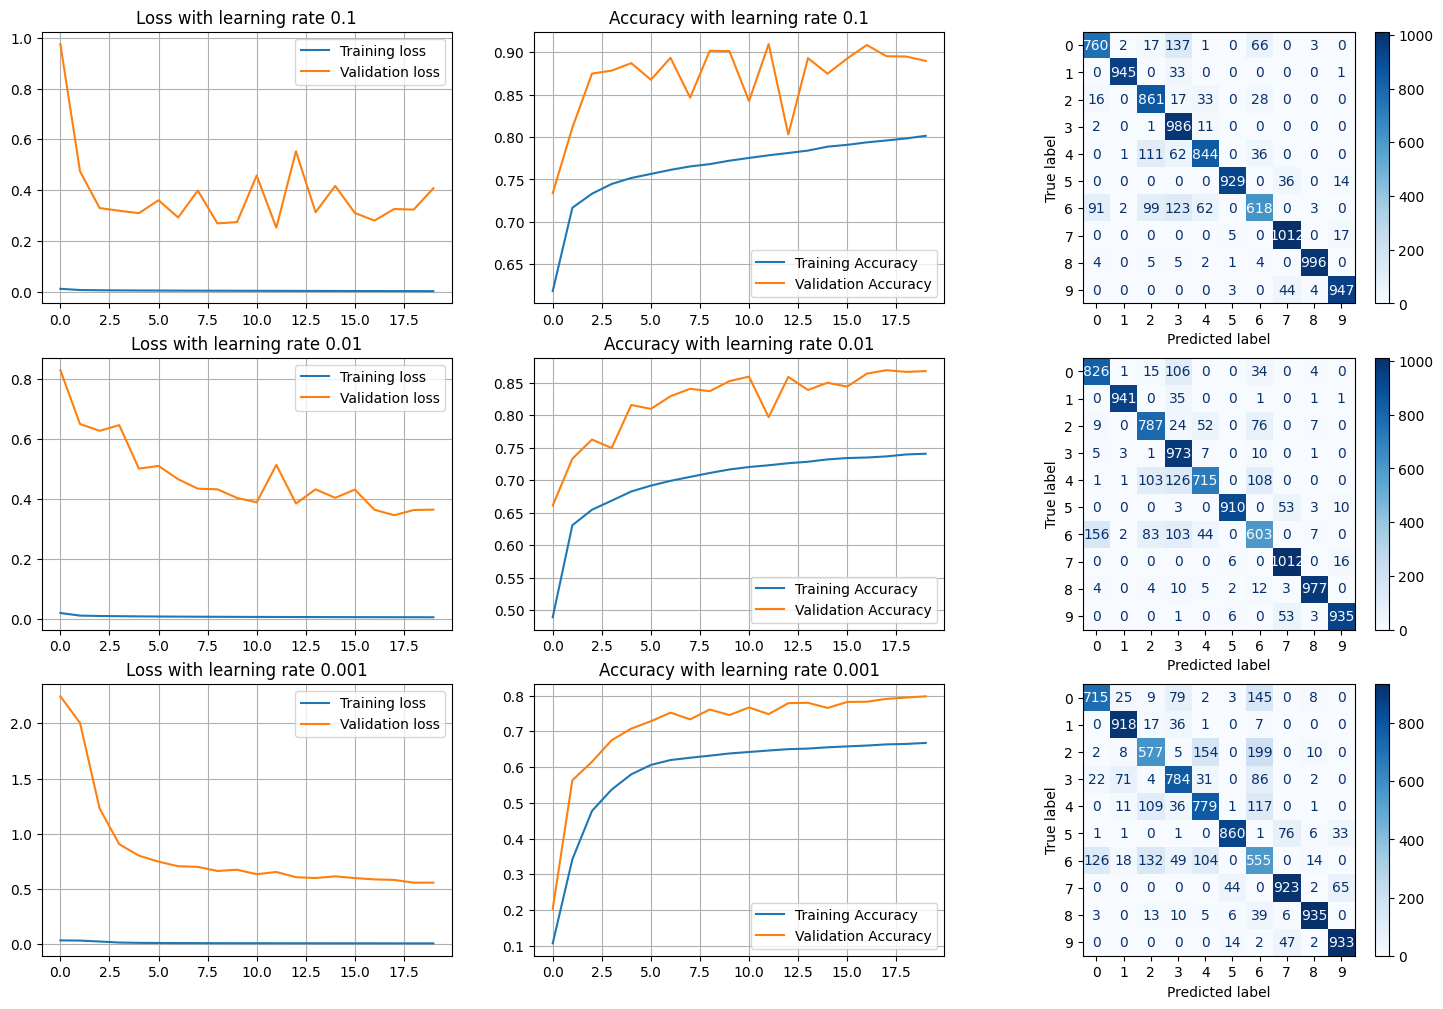

In [15]:
# trying out some other learning rates

n_epochs = 20
learning_rates = [1e-1, 1e-2, 1e-3]

fig, axes = plt.subplots(len(learning_rates), 3, figsize=(18, 4 * len(learning_rates)))

for i, lr in enumerate(learning_rates):
    model = cnn_model().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    config = {
        "learning_rate": lr,
        "n_epochs": n_epochs,
    }
    run = wandb.init(entity="michael-jakober", project="ftp_delearn_05", name=f"SGD_LR{lr}", config=config)

    train_losses, val_losses, train_accuracies, val_accuracies, predictions, targets = train_eval(model, optimizer,
                                                                                                  n_epochs, train_loader,
                                                                                                  validation_loader,
                                                                                                  verbose=False,
                                                                                                  wandb_run=run)
    axes[i, 0].plot(train_losses, label='Training loss')
    axes[i, 0].plot(val_losses, label='Validation loss')
    axes[i, 0].set_title(f"Loss with learning rate {lr}")
    axes[i, 0].legend()
    axes[i, 0].grid()

    axes[i, 1].plot(train_accuracies, label='Training Accuracy')
    axes[i, 1].plot(val_accuracies, label='Validation Accuracy')
    axes[i, 1].set_title(f"Accuracy with learning rate {lr}")
    axes[i, 1].legend()
    axes[i, 1].grid()

    cm = confusion_matrix(targets, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i, 2], cmap="Blues")

plt.show()


# Comments
We achieve the best result with a learning rate of 0.1. However, with a lower learning rate, it runs smoother.

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


In [16]:
n_epochs = 10
splits = 5
k_fold = KFold(n_splits=splits, shuffle=True)
full_dataset = ConcatDataset([training_data, validation_data])

accuracies = []

for fold, (train_ids, test_ids) in enumerate(k_fold.split(full_dataset)):
    train_subset = Subset(full_dataset, train_ids)
    val_subset = Subset(full_dataset, test_ids)

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

    model = cnn_model().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    config = {
        "learning_rate": 0.1,
        "n_epochs": n_epochs,
    }
    run = wandb.init(entity="michael-jakober", project="ftp_delearn_05", name=f"SGD_LR0.1_kfold{fold}")
    cost_hist, cost_hist_val, acc_hist, acc_hist_val, _, _ = train_eval(model, optimizer, n_epochs, train_loader, val_loader, verbose=False, wandb_run=run)
    accuracies.append(acc_hist_val[-1])

Epoch: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


train_acc,▁▅▇▇▇██▇██████▇▇██▇███████████▇▇████████
train_loss,█▃▅▃▃▃▃▄▃▃▃▂▁▂▂▂▂▂▃▃▁▁▂▂▂▂▃▂▂▂▂▂▂▂▃▃▂▁▁▁
val_acc,▂▁▄▂▂▂▄▄▆▅▄▄▃▅▃▁▅▆▄▅▅▆▄▅▅▅▇▄▄▆▇▄▇▅▇█▅▅▃▅
val_loss,▇▆▇▆▅▄█▆▄▅▃▆▄▄▃▅▅▃▃▂▅▃▃▄▂▄▃▇▃▅▄▂▄▂▃▄▅▄▁▄
train_acc,0.95312
train_loss,0.19116
val_acc,0.96875
val_loss,0.08565


Epoch: 100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


train_acc,▁▁▁▅▃▁▂▅▅▆▅▅▄▄▇▅▇▇▅▅▅▅▃▅▅▃▅▇▇▅▄▆▇▃▆▇█▅▅▅
train_loss,▇▅▅██▂▅▃▅▆▃▂▆▃▅▃▂▅▁▃▂▂▂▃▄▆▁▁▂▂▂▄▃▃▃▄▃▁▃▃
val_acc,▄▅▅▄▆▃▄▅▄▃▁▅▃▆▅▅▆▄▃▅▄▆▆▆▆▆▅▅▅▆▆▇▇▆▆█▆▇▆▅
val_loss,▅█▆▄▄▂▃▂▅▇▃▁▅▄▃▃▄▄▄▆▄▂▂▃▄█▅▆▃▃▂▅▃▃▃▂▃▂▃▁
train_acc,0.96875
train_loss,0.14572
val_acc,0.9375
val_loss,0.22953


Epoch: 100%|██████████| 10/10 [01:44<00:00, 10.42s/it]


train_acc,▁▅▃▄▆▄▆▅▃▆▄▅▄▅▆▆▆▅▆▆▄▆▇▆▅▆▆▆▆▆▇▇▇▇▆▇█▄▆▆
train_loss,█▆▃▃▂▄▃▂▃▂▃▂▃▂▁▃▂▃▂▂▁▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▁▂▂
val_acc,▁▇▁▅▇▅▆▇▄▅▆▇▃▅▆▆▇▇▅▇▇▅▅▅▇▇▇▇▇▇▅▇▆▇▆▅█▆▇▅
val_loss,▅▆▆█▇▃▄▄▅▆▆▄▅▆▂▆▃▆▂▅▆▅▃▃▇▄▆▂▅▄▇▂▁▃▃▃▄▄▂▆
train_acc,0.9375
train_loss,0.22378
val_acc,0.84375
val_loss,0.54356


Epoch: 100%|██████████| 10/10 [01:39<00:00,  9.99s/it]


train_acc,▁▇▆▆▅▆▆▇▆▇▆▇▆▇▇█▆▇█▇▇███████▇█▇▇████▇▇▇█
train_loss,█▇▄▆▅▇▄▄▃▂▂▄▂▂▄▂▅▁▁▁▂▂▁▁▃▂▃▂▂▂▁▁▂▁▃▄▁▃▁▂
val_acc,▃▂▂▁▂▆▄▂▅▄▅▆▆▆▅█▅▄▇▅▇█▆▇▇▆▄▆▄▆▅▇▇▇▅█▅▅▆▆
val_loss,▆▅▅█▆▂▃▁▄▄▃▂▂▃▂▁▃▂▄▄▂▄▁▁▃▃▂▂▃▅▂▂▃▁▁▄▄▁▂▂
train_acc,0.95312
train_loss,0.10651
val_acc,0.8125
val_loss,0.49419


Epoch: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


train_acc,▂▃▁▆▄▇▅▅▃▅▄▅▅▆▆▆█▅▅▆▅▅▃▆▇█▇▆▄▆▇▆▇▆▅▆██▇▇
train_loss,█▄▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▁▂▁▁▂▂▁▂▁▂▂▁▁▂▁▁
val_acc,▄▄▂▂▂▃▂▆▁▂▇▅▄▅▆▄▂▅▆▅▂▇▂▃▆▇▃▅▆▂▃█▆▆▄▅▇▄▆▆
val_loss,▅█▅▄▅▃▅▃▅▅▆▃▃▃▃▇▂▄▃▅▂▁▃▁▁▄▃▁▂▁▅▃▂▁▄▂▄▂▄▂
train_acc,0.96875
train_loss,0.14982
val_acc,0.9375
val_loss,0.31467


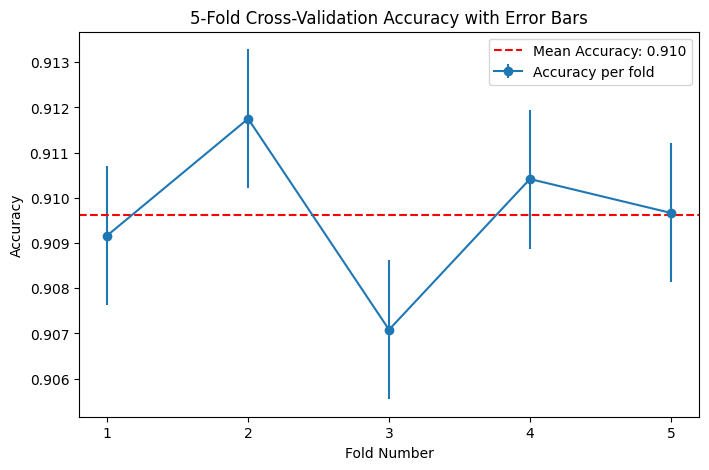

In [17]:
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

plt.figure(figsize=(8, 5))
plt.errorbar(range(1, splits+1), accuracies, yerr=std_acc, fmt='o-', label="Accuracy per fold")
plt.axhline(mean_acc, color='r', linestyle='--', label=f"Mean Accuracy: {mean_acc:.3f}")
plt.xlabel("Fold Number")
plt.xticks(range(1, splits + 1))
plt.ylabel("Accuracy")
plt.title("5-Fold Cross-Validation Accuracy with Error Bars")
plt.legend()
plt.show()

# Comments
We see good accuracies across all folds, however, the fold nr. 3 seems to be performing worse than the others, even when including the standard deviation.

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [18]:
def get_title(metric, optimizer, lr, setting1, setting2):
    title = f"{metric} with {optim_string}, LR: {lr}, "
    if optimizer == "Momentum":
        title += f"Momentum {setting1} and {'with' if setting2 else 'without'} Nesterov"
    elif optimizer == "RMSProp":
        title += f"Alpha {setting1} and centered={setting2}"
    elif optimizer == "Adam":
        title += f"beta1 {setting1} and beta2 {setting2}"

    return title

Epoch: 100%|██████████| 5/5 [00:48<00:00,  9.63s/it]


train_acc,▁▅▅▆▇▆▅▇▇█▆▇▇▇▇▇▆▇█▇█▇▇█▆█▆▆▆▇▇▆▇█▇▇█▇▇▇
train_loss,█▄▄▃▃▂▃▃▃▂▄▂▂▂▂▂▂▂▄▂▁▂▂▁▄▄▂▂▂▂▂▂▃▃▂▂▃▂▁▁
val_acc,▂▇▆█▆▂▅▄▁▃▅▃▃▄▅▇▃▄▄▃▅▆▆▆▅▆▅▃▃▅▃▄▆▅▄▆▄▆▆▁
val_loss,▄▅▅█▃▅▄▂▃▄▃▇▁▁▂▃▃▇▄▃▅▃▃▅▃▅▃▃▂▃▂▂▁▄▁▇▃▃▃▄
train_acc,0.89062
train_loss,0.36255
val_acc,0.8125
val_loss,0.42316


Epoch: 100%|██████████| 5/5 [00:45<00:00,  9.15s/it]


train_acc,▂▁▆▆▆▆▆▆▇▆█▇▇▇█▇█▇█▇▇▇█▇█▇███▇█▇██▇▇█▇█▇
train_loss,█▅▅▇▆▅▄▃▃▃▄▃▃▄▃▃▂▃▃▂▂▃▂▂▂▂▄▂▄▂▁▁▁▂▂▂▁▂▂▁
val_acc,▄▂▂▂▂▅▄▄▂▃▇▅▄▇▄▃▃▄▂▂▄▃▆▃▂▄▃▃▅▅▅▇▅█▁▄▄▅▃█
val_loss,▄▅▄▃▄▆▅▃▅▃▃▇▅▄▄▆▃▃▄▄▃▇█▅▅▄▁▅▃▃▄▄▂▆▃▃▂▆▅▁
train_acc,0.875
train_loss,0.34546
val_acc,0.8125
val_loss,0.32695


Epoch: 100%|██████████| 5/5 [00:44<00:00,  8.97s/it]


train_acc,▁▅▆▆▆▇▇▇▆▆▆▆▇▇▆▇▇▆▆█▇▆▇▆██▇▇█▇▇▆▇▆▇▇█▇█▇
train_loss,▅▆▇▆▄▆▅▄▁▄▅▄▄▃▄▄▃▅▅▄▄▆▆█▄▃▄▃▅▇▃▇▄▄▄▄▄▃▃▄
val_acc,▇▁▅▄█▅▅▅▅▅▃▂▄▄▇▄▃▅▅▅▅▆▆▄▄▇▅▆▇▄▃▅▆▇▅▅▅█▅▅
val_loss,▃▆▆▃▄▅▂▅█▄▄▄▇▆▃▅▄▃▄▄▇▂▇▄▂▂▅▄▄▂▅▂▂▅▃▃▅▁▅▄
train_acc,0.92188
train_loss,0.21353
val_acc,0.9375
val_loss,0.1312


Epoch: 100%|██████████| 5/5 [00:45<00:00,  9.12s/it]


train_acc,▁▂▃▃▅▇▅▄▇▇▇▇▇▆▇▇██▇▅██▆▆▅▇▅▇▇▇▇▅▇█▇▆▇▆█▇
train_loss,█▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▂▂▂▂▂▂▁▁▁▂▂▂
val_acc,▁▃▅▄▄▃▄▁▄▄▅▇▆▄▅▆▅█▅▃▇▆▇▃▇█▅▆▅▇▇█▇▇▇▅▆▇▅▆
val_loss,▇▄██▇▁▂▃▆▄▆▂▃▁▃▂▂▂▄▅▄▂▆▂▁▃▂▂▂▃▁▄▄▄▂▂▃▄▁▂
train_acc,0.89062
train_loss,0.45737
val_acc,0.75
val_loss,0.35384


Epoch: 100%|██████████| 5/5 [00:44<00:00,  8.99s/it]


train_acc,▃▇█▂▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▂▁▁
train_loss,▁▁▃███▇████████████▇██▇████████████▇████
val_acc,▃▃█▃▄▆▆▄▃█▁▂▄▄▁▅▁▄▅▃▅▁▇▁▂▇▄▄▃▆▇▅▅▅▃▂▇▄▆▅
val_loss,▄▃▁▅▅▅▄▄▆█▃▄▃█▂▂▄▄▆▃▄▅▆▅▄▄▃▅▂▆▄▆▇▄▆▄▄▅▄▃
train_acc,0.10938
train_loss,2.32901
val_acc,0.0625
val_loss,2.35499


Epoch: 100%|██████████| 5/5 [00:44<00:00,  8.96s/it]


train_acc,▁▂▂▅▇▅▃▅▇▄▄▆▄▆▆▆▅▆▅▆▆██▆▆▅▆▅▇▇█▆▇▇▆▆▇▇▅▅
train_loss,█▃▃▂▂▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▃▂▂▁▁▁▁▂▂▁▂▁▁▂▂▂
val_acc,▆▁▂▅▅▅▅▅▅▃▅▅▅▅▅▃▃▁▅▅▅▃▄▅▃▃▅▄▃▃▆▂▃▅▅▅▇▄▅█
val_loss,▆█▄▃▇▆▄▆▇▂▃█▄██▆▆▄▅▁▅▁▅▂▃▅▅▃▄█▄▂▃▇▁▄▄▅▄▄
train_acc,0.82812
train_loss,0.30902
val_acc,0.8125
val_loss,0.65781


Epoch: 100%|██████████| 5/5 [00:45<00:00,  9.05s/it]


train_acc,███▆▁▁▂▁▁▂▂▁▁▂▂▂▁▂▁▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▁▂▂▂▁
train_loss,▁▁██████████████████████████████████████
val_acc,▄▄▅▇▁▄▁▄▅▅▂▇▆▆▇▅▆▅▆█▂▅▄▅▅▅▃▆▅▅▄▅▃▅▂▇▄▃▅▅
val_loss,▄▃▃▄▄▄▃▅▁▄▄▅▄▁▅█▆█▇▃▃▆▄▃▅▅▃▄▁▅▅▅▃▆▄▅█▃▅▃
train_acc,0.15625
train_loss,2.31486
val_acc,0
val_loss,2.32895


Epoch: 100%|██████████| 5/5 [00:45<00:00,  9.05s/it]


train_acc,▅▄▁▅▅▄▃▄▅▄▆▄▂▅▃▇▄▇▄▅▄▅▇▆▆█▆▅▄▆▇▇▅▆▄▇█▃▇▆
train_loss,▇▅▅▄▆▇▅▄▆▄▇▃▃▃▅▇▃▃▄▆▃▅▅▆▅▂▄▄▃▇▃█▄▆▃▂▁▄▅▃
val_acc,▄▃▃▆▆▄▃▅▁▅▃▆▃▅▄▅▃▃▇▄▆▄▄▅▅█▄▁▅▃▇▃▄▄▅▃▃▃▆▃
val_loss,▃▆█▅▆▅▅▅▄▄▁▅▅▅▅▄▄▆▃▅▃▅▂▇▆▄▂▄▄▃▅▄▄▃▃▃▄▄▂▂
train_acc,0.89062
train_loss,0.1804
val_acc,0.9375
val_loss,0.18438


Epoch: 100%|██████████| 5/5 [00:46<00:00,  9.23s/it]


train_acc,▄▂▅▄▅▅▅▅▄▄▂▅▄▅▆▅▄▄▅▄▅█▄▁▅▅▃▃▅▅▅▅▆▅▄▄▅█▅▄
train_loss,█▄▅█▆▇▅▆▆▆▃▄▆▆▆▆▅▅▆▆▆▆▆▅█▅▆█▄▅▆▄▆▁▆▇▇▇▄█
val_acc,▅▅▅▂▂▇▂▂█▇▅▄▅▄▆█▆▃▃▄▅▆▁▅▄▂▂▄▄▃▅▃▁▅▆▄▄▅▃▃
val_loss,▇▄▃▄▄▅▇█▃▇█▄▇▆▅▂▅▅▆▁█▄▄▂▇▃▇▅▂█▅▅▅▅▃▆▇▅▄▃
train_acc,0.09375
train_loss,2.31776
val_acc,0.0625
val_loss,2.31763


Epoch: 100%|██████████| 5/5 [00:44<00:00,  8.98s/it]


train_acc,▂▅▁▅▃▄▄▅▃▄▄▇▂▄▂▆▅▄▄▄▅▄▄▃▂▆▄▅▅█▂▆▄▄▄▃▃▂▅▄
train_loss,▅▄▆▅▅▃▂▇▅▄▅▇▆▇▆▆▂▂▅▅▅▅▇▄▆▅▄▄▃▄▄█▁▇▇▅▄▃▄▅
val_acc,▅▅▄▃▄▆▅█▅▅▁▆▃▅▂▆▅▆█▂▅▄▇▆▇▆▃▅▇▅▃▆▆▅▇▅▇▅▆▄
val_loss,▂▆▆▆▅▅▆▅▆▆▁▆▅▆▇▅▇▆█▆▇▄▄▅▄▃▃▄▇▃▅▇▄▇▄▄▄▅▄▅
train_acc,0.07812
train_loss,2.30209
val_acc,0
val_loss,2.29611


Epoch: 100%|██████████| 5/5 [00:45<00:00,  9.04s/it]


train_acc,▄▅▄▆▅▄▆▆▆▃▅▁▆▃▇▆▃▄▃▅▂▄█▄▆▃▃▃▅▆▃▂▃▄▆▄▃▂▃▆
train_loss,▅█▄▆▆▃▃▃▄▆▃▆▂▇▅▅▃▁▆▃▅▄▅▆▄▇▅▆▂▅▄▄▃▅▃▂▆▆█▅
val_acc,▁▂▂▁▂▂▂▂▂▂▃▂▂▁▂▂▅▂▃▃▃▃▃█▂▁▄▂▂▁▄▃▂▁▂▅▃▂▄▄
val_loss,▂▁▆▅▄▅▂▆▆▅▄▄▂▃▃▃▇▄▄▄▇▆▄▆▅▃▃▄▁▆▃▅▅▁▄▄▄▆▃█
train_acc,0.07812
train_loss,2.30881
val_acc,0
val_loss,2.31386


Epoch: 100%|██████████| 5/5 [00:46<00:00,  9.30s/it]


train_acc,▃▆▃▅▇▁▄▂▅▃▄▆▃▄▄▄█▅▄▆▅▃▆▃▂▁▂▅▃█▂▄▅▆▆▅▅▃▅▄
train_loss,▆▅▇▅▅▄▂▅▇▆▃▅▆▂▅▇▆▆▆▄▆▆▆▁▆▆▇▇█▇▅▅▆▆▆▆▆▆▄▅
val_acc,▇▂▇▅▆▆▄▇█▁▂▅▅▅▃▃▇▅▇▇▇▅▆▅▂▅▅▄▅██▄▅▂▇▅▅▃▇▅
val_loss,▁▄▅▄▃▅▂▄▆▅▄▄▁▄▅▄▄▃▅▄▆▆▅▄▄▆▃▅█▆▂▅▅▆▃▄▆▂▆▃
train_acc,0.10938
train_loss,2.30221
val_acc,0.1875
val_loss,2.30897


Epoch: 100%|██████████| 5/5 [00:44<00:00,  8.92s/it]


train_acc,▂▄▃▅▂▅▆▃█▆▅▅▃▅▃▅▆▃▇▆▄▆▆▆▆▅▂▅▅▄▂▅▅▅▁▄▅▅▅▇
train_loss,▄▂▃▅▅▅▂▅▂▄▅▂▄▅▃▄█▆▄▄▁▄▅▆▇█▆▁█▄▂▅▄▃█▄▆▄▄▃
val_acc,▂▁▅▂▂▃▇▇▂▄▄▅▂▃▃▇▄█▅▂▂▆▁▂▇▆▆▃▂▅▄▅▂▇▂▃▂▂▅▅
val_loss,▂▅▃▂▅▆▃▂▅▆▂▄▂▆▂█▃▃▃▃▄▅▂▅▄▆▆▆▄▃▃▃▅▅▆▃▆▆▆▁
train_acc,0.10938
train_loss,2.30419
val_acc,0.125
val_loss,2.30205


Epoch: 100%|██████████| 5/5 [00:45<00:00,  9.16s/it]


train_acc,▆▅▇▅▄▇▄▇▄▇█▅▄▇▅▇▅▇▄▅▅▃▄▄▇▂▁▆▅▅▆▄▅▇▆▄▄▅▄▃
train_loss,▁▃▂█▅▃▄▅▂▃▆▅▆▃▄▅▂▅█▅▆▅█▅▅▅▄▅▅▄▄▄▄▄▄▅▃▂▅▄
val_acc,▃▅▃▂▄▆█▅▅▂▃▄▄▁▁▁▄▃▃▁▃▃▆▁▂▆▂▃▃▅▂▃▃▅▃▂▃▅▃▄
val_loss,▅▅▄▅▄▄▅█▆▃▁▇▇▅▃▇▇▃▇▆▅▄▅▄▆▄▅▆█▃▄▆▆▅▆▄▄▄▄▅
train_acc,0.04688
train_loss,2.31111
val_acc,0.25
val_loss,2.29019


Epoch: 100%|██████████| 5/5 [00:47<00:00,  9.43s/it]


train_acc,▇▆▄▂▂▂▅▆▇▅▃▅▄▇█▆▆▆▁▇▅▅▆▁▅▆▇▇▅█▃▅▆▇▃▇▄▆▇▅
train_loss,▆▃▆▁▅▅▂▁▃█▇▅█▃▃▂▄▂▆▄▄▃▆▄▅▇▄▃▆▂▅▇▄▃█▆▅▄▇▇
val_acc,▇▄▃▅▅█▄▃▃▇▅▂█▅▅▂▄▃▅▅▅▅▄▄▅▂▁▂▅▄▃▃▇▆▅▇▂▂▄▇
val_loss,▇▅█▂▅▅▄▅▅▄▇▄▄▃▅▄▁▂▅▄▄▂▄▅▅▄▅▅▆▆▆▅▃▃▅▅▆▂▄▄
train_acc,0.125
train_loss,2.29971
val_acc,0.0625
val_loss,2.28925


Epoch: 100%|██████████| 5/5 [00:47<00:00,  9.43s/it]


train_acc,▆▃▂▄▁▂▃▂▆▅█▃▅▁▃▂▃▃▇▅▄▅▃▃▃▆▃▄▄▁▃▃▃▅▆▅▄▃▃▂
train_loss,▄▅▃▆▄▇▅▄▅▂▅▁▄▃▇▆▁▅▆▅▆▄▄▆▇▅▄▁▆▄██▆▇▇▆▅▅▂▆
val_acc,▄▅▃▃▅▅▅▅▃▃▆▂▅▃█▅▄▁▃▆▅▂▇▅▂▂▄▅▃▁▅▄▆▄▁▅▄▇▇▂
val_loss,▃▄▄▅▃▁▅▂▅▄▄▃▅▂▃▅▄▄█▃▃▁▄▅▅▂▄▄▆▅▂▃▅▅▃▁▂▆▅▃
train_acc,0.0625
train_loss,2.30703
val_acc,0.0625
val_loss,2.29019


Epoch: 100%|██████████| 5/5 [00:46<00:00,  9.38s/it]


train_acc,▁▅▆▆▅▆▆▇█▇▇█▇▇█▇█▆▇▇▇▇█▇▇███▇▇██▇█▇▇█▇▇▇
train_loss,█▇▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▂▁▂▁▁▂▁▂▂▂▂▂▂
val_acc,▅▄▆▃▆▃▆▃▆▄▁▅▆▅▃▆▅█▇▅▅▅▄▇▅▅▆▇▅▅▅▇▅▄▇▆▃▅▅█
val_loss,▇▇▇▃▅▇▆▄▃▇▇▄▆▁▆▄▄▁▃▂█▅▄▇▂▅▆▃▃▄▂▄▂▄▆▃▄▁▄▆
train_acc,0.9375
train_loss,0.18549
val_acc,0.9375
val_loss,0.08389


Epoch: 100%|██████████| 5/5 [00:47<00:00,  9.50s/it]


train_acc,▁▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇██▇█▇▇▇█▇▇█▇█████▇█▇█
train_loss,██▅▃▃▃▃▃▃▂▃▃▃▂▃▃▃▃▂▂▂▂▂▃▂▃▂▂▁▂▃▂▂▂▂▂▂▁▂▁
val_acc,▂▁▂▅▃▁▅▃▄▄▅▂▂▃▃▅▃▇▃▄▃▄▇▂▆█▃▄▅▅▄▄▃▃▅▅▅▅▄▄
val_loss,▄▆▅▄▄█▅▆▇▅▄▃▄▇▄▃▆▅▃▂▃▄▃▃▅▄▄▃▃▄▂▃▆▂▄▅▃▃▅▁
train_acc,0.89062
train_loss,0.34023
val_acc,1
val_loss,0.04011


Epoch: 100%|██████████| 5/5 [00:48<00:00,  9.60s/it]


train_acc,▁▄▆▆▅▇▆▇▇▆▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇██▇▇██▇▇▇▇█▇▇█
train_loss,█▄▃▄▄▃▃▂▃▂▂▃▂▂▂▂▄▁▃▁▃▂▃▁▂▁▃▁▂▂▁▁▁▃▁▃▁▂▂▂
val_acc,▂▂▄▃▄▅▃▄▃▂▅▃▄▅▆▁▃▄▅▅▆▂█▅▄▅▇▄▅▄▆▅▅▄█▅▅▇▅▆
val_loss,▃▆█▄▅▅▃▄▅▂▅▃▆▄▅▅▃▃▄▃▅▃▅▃▂▃▃▃▅▃▃▃▆▂▃▂▁▃▂▂
train_acc,0.95312
train_loss,0.18646
val_acc,0.875
val_loss,0.26295


Epoch: 100%|██████████| 5/5 [00:45<00:00,  9.17s/it]


train_acc,▁▂▁▃▁▅▅▅▇▆█▆▆▆▆▆▆▅▆▇█▄▆▇▆▆▆▆▇▅▇█▆▆█▆█▅▆▅
train_loss,█▅▅▅▄▃▃▅▃▃▂▂▄▄▃▄▃▃▃▃▁▃▄▃▁▃▁▂▄▄▂▅▂▁▂▄▁▃▃▁
val_acc,▄▃▃▅▃▅▆▁▅▅▃▄▇▆▅▇▃▄▆▅▅▅▃▄▆▃▆▆▅▅▅▆▇▅▃▄▅▇▇█
val_loss,▅▅█▄▄▃▄▁▆▄▃▃▃▅▃▃▃▂▂▁▅▁▃▁▃▁▂▃▃▃▃▆▃▃▅▁▅▆▃▂
train_acc,0.92188
train_loss,0.21012
val_acc,0.875
val_loss,0.21357


Epoch: 100%|██████████| 5/5 [00:46<00:00,  9.29s/it]


train_acc,▂▅▁▃▄▂▂▃▅▅▅█▇▅█▇▅▆▇▄▅▇▅▇▅▇█▇▆▃▇▇▇▇▇▇▇▅▇█
train_loss,█▄▅▃▅▄▃▅▄▃▆▃▃▃▃▃▃▂▃▃▃▃▂▂▃▃▂▁▁▃▄▃▂▂▃▃▂▃▂▁
val_acc,▅▅▅▂▂▅▅█▅▃▅▆▃▃█▅▆▁▃▅▅▄▆▅▇▆▄▆▅▆▆▅▆▄▆▅▅▆▅▅
val_loss,▇▅█▅▃▄▄▄▇▅▃▄▅▂▁▅▃▄▃▂▅▇▃▂▆▂▃▃▄▄▃▂▇▄▂▄▂▅▂▅
train_acc,0.9375
train_loss,0.22399
val_acc,0.9375
val_loss,0.38887


Epoch: 100%|██████████| 5/5 [00:44<00:00,  8.88s/it]


train_acc,▁▅▆▆▇▇▇▆▆▆▇▇▇▇▇▇█▇▇▇▇█▇▇█▇█▇█▇▇▇▇▇▇▇▇▇██
train_loss,█▄▃▂▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▂▂▂▁▂▂▁▂▁▁
val_acc,▅▄▃▅▂▂▅▅▂▄▄▇▇▅▇▁▂▅▅▇▇▄▆▄▅▄▅▆▇▅▆▇▇██▇▇▆▆▅
val_loss,▄▅▆▄▅██▄▃▅█▄▄▃▂▄▅▅▄▄▃▄▅▂▄▃▃▆▄▃▁▄▅▄▃▂▄▃▃▃
train_acc,0.92188
train_loss,0.14505
val_acc,0.875
val_loss,0.11477


Epoch: 100%|██████████| 5/5 [00:46<00:00,  9.23s/it]


train_acc,▆▃█▄▆▃▅▂▃▃▄▃▁▂▂▁▂▃▁▃▅▁▁▂▂▄▂▄▄▄▃▄▃▂▃▆▂▂▄▂
train_loss,▁▁▁▁▁▁▁▂▁▂▁▂▂▁▃▃▃▁▁▂▃▃▂▇▁▃▄▅▃▂█▆▁▂▃▂▄▃▁▇
val_acc,█▅▃▅▅▄▅▅▅▆▄▃▄▆▆▃▅▆▃▁▄▃▅▃▅▅▃▄▃█▃█▄▅▄▃▅█▅▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁█▁▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.04688
train_loss,1.4899402395277874e+32
val_acc,0
val_loss,2.3120095067235386e+32


Epoch: 100%|██████████| 5/5 [00:47<00:00,  9.49s/it]


train_acc,▇▇▇▃▇██▇▇▆▂▁▁▁▂▁▁▂▂▂▁▂▂▁▂▁▂▂▁▂▁▂▂▁▂▂▂▂▂▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,███▇█▇▇▇▇▁▂▁▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▂▂▁▂▁▂▂▂▂▂▁▁▄
val_loss,▁▂▂▁▂▁██████████████████████████████████
train_acc,0.125
train_loss,2.30278
val_acc,0.3125
val_loss,2.29761


Epoch: 100%|██████████| 5/5 [00:46<00:00,  9.29s/it]


train_acc,▁▁▂▂▅▅▄▇▄▃▄▅▅▄▃▄▆▅▅▇▆▄▆▇▆▅▅▅▆▅▆▆▆▇▆█▇▄█▇
train_loss,▆▆▆▄█▄▆▅▃▃▃▆▅▄▅▃▆▅▃▃▂▄▃▃▄▂▃▅▂▃▂▂▄▂▁▁▂▁▃▃
val_acc,▄▅▃▅▆▄▁▃▃▅▅▃▄▄█▄▅▆▆▆▄▆▆▆▅▄▇▅▅▆▆▃▆▄▄▅▆▅▆▅
val_loss,▄▆█▄▆▅▄▅▅█▃▇▃▅▇▃▆▄▅▆▂▂▂▄▃▄▁▃▃▁▃▁▄▆▃▄▄▄▂▃
train_acc,0.95312
train_loss,0.16454
val_acc,0.9375
val_loss,0.36414


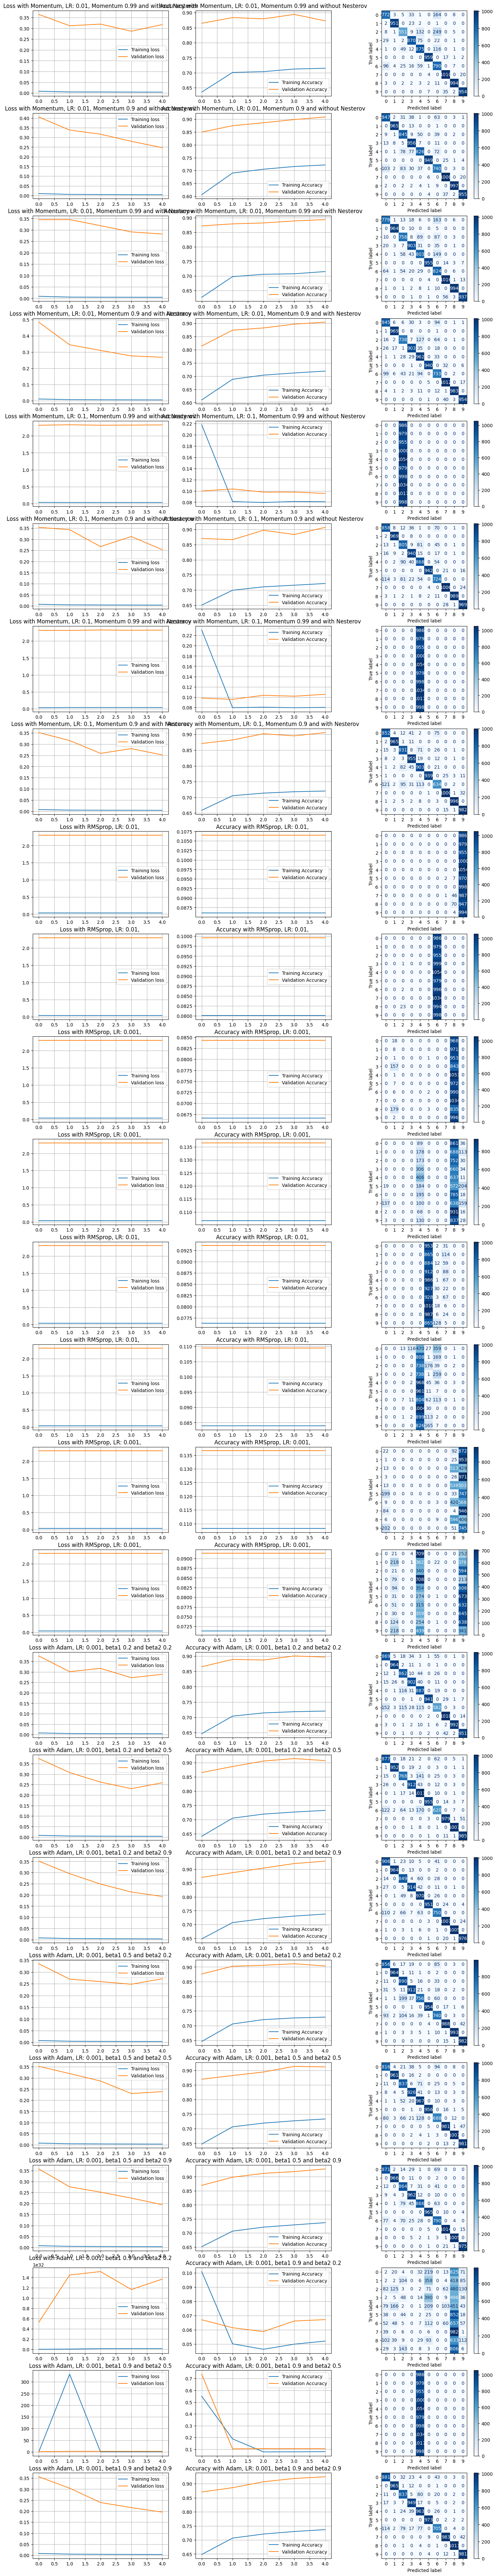

In [22]:
n_epochs = 5

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

optimizers = ["Momentum", "RMSProp", "Adam"]

settings = [
    ["Momentum", 0.01, 0.99, False], # Type, LR, Momentum, Nesterov
    ["Momentum", 0.01, 0.9, False],
    ["Momentum", 0.01, 0.99, True],
    ["Momentum", 0.01, 0.9, True],
    ["Momentum", 0.1, 0.99, False],
    ["Momentum", 0.1, 0.9, False],
    ["Momentum", 0.1, 0.99, True],
    ["Momentum", 0.1, 0.9, True],
    ["RMSprop", 0.01, 0.9, False], # Type, LR, Alpha, centered
    ["RMSprop", 0.01, 0.8, False],
    ["RMSprop", 0.001, 0.9, False],
    ["RMSprop", 0.001, 0.8, False],
    ["RMSprop", 0.01, 0.9, True],
    ["RMSprop", 0.01, 0.8, True],
    ["RMSprop", 0.001, 0.9, True],
    ["RMSprop", 0.001, 0.8, True],
    ["Adam", 0.001, 0.2, 0.2], # Type, LR, Beta1, Beta2
    ["Adam", 0.001, 0.2, 0.5],
    ["Adam", 0.001, 0.2, 0.9],
    ["Adam", 0.001, 0.5, 0.2],
    ["Adam", 0.001, 0.5, 0.5],
    ["Adam", 0.001, 0.5, 0.9],
    ["Adam", 0.001, 0.9, 0.2],
    ["Adam", 0.001, 0.9, 0.5],
    ["Adam", 0.001, 0.9, 0.9],
]

fig, axes = plt.subplots(len(settings), 3, figsize=(18, 4 * len(settings)))

for i, (optim_string, lr, setting1, setting2) in enumerate(settings):
    model = cnn_model().to(device)
    if optim_string == "Momentum":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=setting1, nesterov=setting1)
    elif optim_string == "RMSProp":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=setting1, centered=setting2)
    elif optim_string == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(setting1, setting2))

    run_name = f"{optim_string}_LR{lr}_"
    config = {}
    if optim_string == "Momentum":
        run_name += f"Momentum{setting1}Nesterov{setting2}"
        config = {
            "learning_rate": lr,
            "n_epochs": n_epochs,
            "momentum": setting1,
            "nesterov": setting2,
        }
    elif optim_string == "RMSprop":
        run_name += f"Alpha{setting1}Centered{setting2}"
        config = {
            "learning_rate": lr,
            "n_epochs": n_epochs,
            "alpha": setting1,
            "centered": setting2,
        }
    elif optim_string == "Adam":
        run_name += f"Beta1{setting1}Beta2{setting2}"
        config = {
            "learning_rate": lr,
            "n_epochs": n_epochs,
            "beta1": setting1,
            "beta2": setting2,
        }

    run = wandb.init(entity="michael-jakober", project="ftp_delearn_05", name=run_name, config=config)
    train_losses, val_losses, train_accuracies, val_accuracies, predictions, targets = train_eval(model, optimizer,
                                                                                                  n_epochs, train_loader,
                                                                                                  validation_loader,
                                                                                                  verbose=False,
                                                                                                  wandb_run=run)
    axes[i, 0].plot(train_losses, label='Training loss')
    axes[i, 0].plot(val_losses, label='Validation loss')
    axes[i, 0].set_title(get_title("Loss", optim_string, lr, setting1, setting2))
    axes[i, 0].legend()
    axes[i, 0].grid()

    axes[i, 1].plot(train_accuracies, label='Training Accuracy')
    axes[i, 1].plot(val_accuracies, label='Validation Accuracy')
    axes[i, 1].set_title(get_title("Accuracy", optim_string, lr, setting1, setting2))
    axes[i, 1].legend()
    axes[i, 1].grid()

    cm = confusion_matrix(targets, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i, 2], cmap="Blues")

plt.show()

### Plots and Comments (for the different steps described above)

# Comments
Lots of runs/settings, that did not work out, like all the RMSprop Runs, which is a bit strange.

Using Momentum seems to work good, but somehow the combination LR: 0.1 and Momentum 0.99 did not work at all, with and without nesterov. Also in the other examples, nesterov did not lead to any significant changes in the outcome.

The best run came when using Adam as the optimizer, a learning rate of 0.001, and the betas (0.2, 0.9), as obtained in weights&biases, which a final validation accuracy of **0.93**.

### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.

Epoch: 100%|██████████| 20/20 [03:11<00:00,  9.58s/it]


train_acc,▃▂▂▄▂▄▂▆▁▂▅▆▇▄▃▇▅▅▇▅▄▅▅▄▅▆▅▆▆▆▄▅▆▆▇▇▇▇▇█
train_loss,█▅▅▅▃▅▃▅▄▃▃▄▅▃▄▅▄▂▂▃▂▃▃▃▁▃▂▂▂▂▂▃▁▂▂▁▁▂▃▁
val_acc,▅▅▆▅▂▇▄▄▄▄▇▅▆▁▇▅▄▆▆▅▇▆▇▆▅▅▆▅▅█▆▅▇▆▇█▇▇▇▆
val_loss,▄▆▆█▄▃▄▄▃▄▄▃▃▃▆▄▄▃▂▄▃▄▃▅▃▂▄▁▂▁▂▂▂▄▃▁▂▂▁▂
train_acc,0.98438
train_loss,0.03797
val_acc,0.9375
val_loss,0.08442


Epoch: 100%|██████████| 20/20 [03:07<00:00,  9.35s/it]


train_acc,▆▇▇▄▅▃▆▆▄▄▃▃▇▁▅▇█▄▅▆▆▃▄▄▄▇▆▆▂▅▃▇▃█▅▆▃▆▄▄
train_loss,▄▄▇▃▃▄▅▃▄▄▅▁▄▄▂█▇▄▄▅▆▅▃▅▅▃▄▄▄▃▄▆▅▃▅▅▇▄▅▇
val_acc,▇▆▄▅▄▅▄▃▅▆▄▄▂▄▅▆▆▃▁▄▄▃▆▄▆▂▃█▄▅▅▅▇▄▃▃▄▃▄▂
val_loss,▂▅▄▇▅▅▃▃▆▆▄▄▃▄▃▃▅▄▅▅▄▆▁▄▄▇▆█▅▅▄▂▂▅▅▆▅▅▃▆
train_acc,0.53125
train_loss,1.87675
val_acc,0.625
val_loss,1.78022


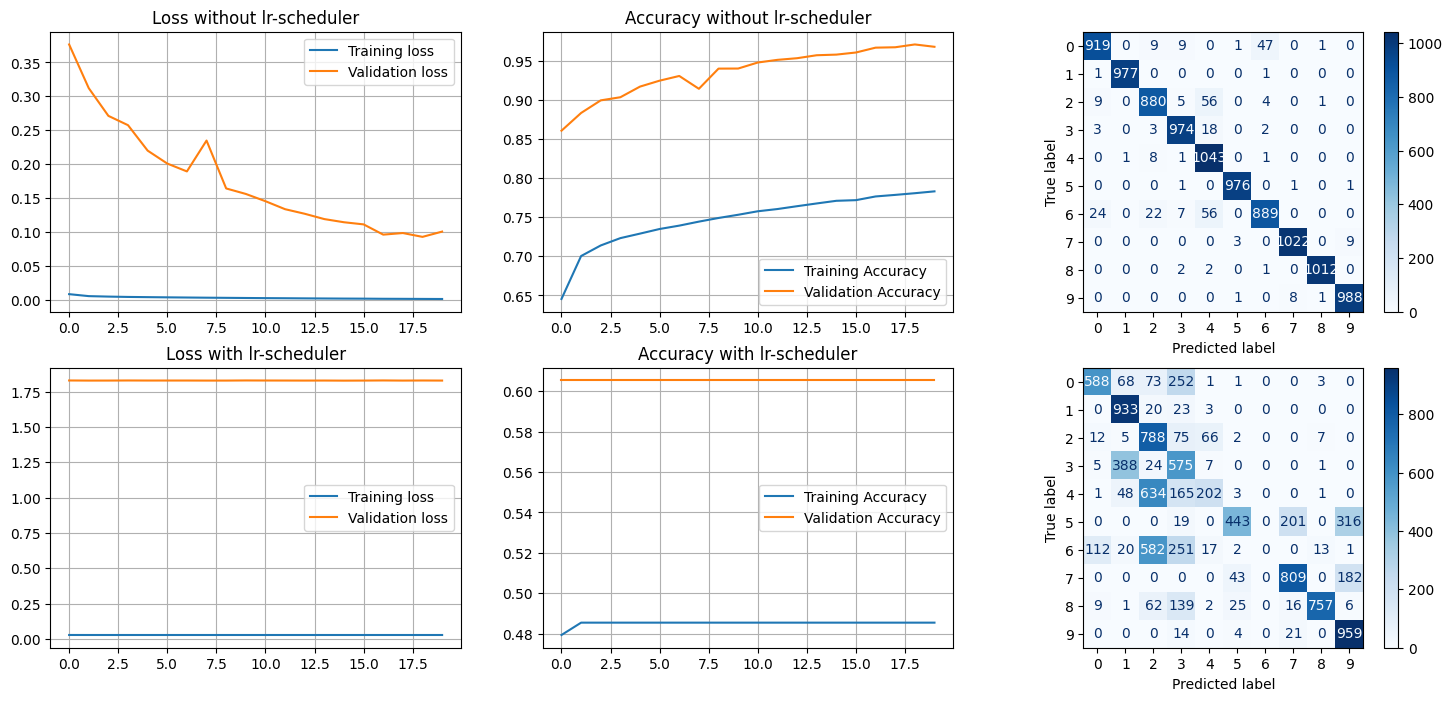

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
n_epochs = 20

# Without scheduler
model = cnn_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

config = {
    "learning_rate": 0.001,
    "n_epochs": n_epochs,
    "scheduler": None,
}

run = wandb.init(entity="michael-jakober", project="ftp_delearn_05", name="Adam_LR0.1_noLRScheduler", config=config)


train_losses, val_losses, train_accuracies, val_accuracies, predictions, targets = train_eval(model, optimizer,
                                                                                              n_epochs, train_loader,
                                                                                              validation_loader,
                                                                                              verbose=False,
                                                                                              wandb_run=run)
axes[0, 0].plot(train_losses, label='Training loss')
axes[0, 0].plot(val_losses, label='Validation loss')
axes[0, 0].set_title(f"Loss without lr-scheduler")
axes[0, 0].legend()
axes[0, 0].grid()

axes[0, 1].plot(train_accuracies, label='Training Accuracy')
axes[0, 1].plot(val_accuracies, label='Validation Accuracy')
axes[0, 1].set_title(f"Accuracy without lr-scheduler")
axes[0, 1].legend()
axes[0, 1].grid()

cm = confusion_matrix(targets, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0, 2], cmap="Blues")

# With scheduler
model = cnn_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

config = {
    "learning_rate": 0.001,
    "n_epochs": n_epochs,
    "scheduler": "StepLR",
    "gamma": 0.5,
    "step_size": 5,
}

run = wandb.init(entity="michael-jakober", project="ftp_delearn_05", name="Adam_LR0.1_withLRScheduler", config=config)

train_losses, val_losses, train_accuracies, val_accuracies, predictions, targets = train_eval(model, optimizer,
                                                                                              n_epochs, train_loader,
                                                                                              validation_loader,
                                                                                              scheduler=scheduler,
                                                                                              verbose=False,
                                                                                              wandb_run=run)
axes[1, 0].plot(train_losses, label='Training loss')
axes[1, 0].plot(val_losses, label='Validation loss')
axes[1, 0].set_title(f"Loss with lr-scheduler")
axes[1, 0].legend()
axes[1, 0].grid()

axes[1, 1].plot(train_accuracies, label='Training Accuracy')
axes[1, 1].plot(val_accuracies, label='Validation Accuracy')
axes[1, 1].set_title(f"Accuracy with lr-scheduler")
axes[1, 1].legend()
axes[1, 1].grid()

cm = confusion_matrix(targets, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[1, 2], cmap="Blues")

plt.show()

# Comments
We tried some different lr-scheduling values, like the starting learning-rate, gamma or the step-size, however, it did not seem to deliver good results, and de best results came when using no scheduler at all.